In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import rasterstats
import rasterio
import requests
from requests.exceptions import HTTPError
import time
import datetime as dt
import os

dt1 = dt.timedelta(days = 1)
dt90 = dt.timedelta(days=92)

format="%Y-%m-%d"

today = dt.datetime.now()
end = dt.datetime.now()-dt1
start = dt.datetime.now()-dt90

print(type(today), today.strftime(format)+"T00:00:00Z")
print('start ', type(end.strftime(format)), start.strftime(format)+"T00:00:00Z")
print('end ', end.strftime(format)+"T00:00:00Z")

Populating the interactive namespace from numpy and matplotlib
<class 'datetime.datetime'> 2019-04-26T00:00:00Z
start  <class 'str'> 2019-01-24T00:00:00Z
end  2019-04-25T00:00:00Z


In [2]:
# delete existing file if it exists
exists = os.path.isfile(r'../Data/test2.nc')
if exists:
#     ds.close()
    os.remove(r'../Data/test2.nc')
    print('removed existing file')

# Url for non-aggragated
url = r'http://thredds.northwestknowledge.net:8080/thredds/ncss/MET/tmmn/tmmn_2019.nc'
payload={'var': 'air_temperature',
        'north': '49.4000',
        'west': '-124.7666',
        'east': '-67.0583',
        'south': '25.0666',
        'horizStride': '1',
        'time_start': start,
        'time_end': end,
        'timeStride': '1',
        'accept': 'netcdf4'}
# Note: when using the non-aggragated server, asking for dates in previous year fails.  Indicates
# that using the aggragated server would be the way to go when traversing a new calander year.

# Url for aggragated
url2 = 'http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc'
payload2={'var': 'daily_maximum_temperature',
        'north': '49.4000',
        'west': '-124.7666',
        'east': '-67.0583',
        'south': '25.0666',
        'disableLLSubset': 'on',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': start,
        'time_end': end,
        'timeStride': '1',
        'accept': 'netcdf4'}
# print(url)
try:
#     myfile = requests.get(url, params=payload)
    myfile = requests.get(url2, params=payload2)
    myfile.raise_for_status()
except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Python 3.6
except Exception as err:
    print(f'Other error occurred: {err}')  # Python 3.6
else:
    print('Success!')
#     print(myfile.headers)
    print(myfile.url)
        
with open(r'../Data/test2.nc', 'wb') as fh:
    fh.write(myfile.content)
    fh.close()

removed existing file
Success!
http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_tmmx_1979_CurrentYear_CONUS.nc?var=daily_maximum_temperature&north=49.4000&west=-124.7666&east=-67.0583&south=25.0666&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2019-01-24+09%3A33%3A10.979677&time_end=2019-04-25+09%3A33%3A10.979677&timeStride=1&accept=netcdf4


In [26]:
import pandas as pd
import geopandas as gpd

print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
print(folder)
shapefiles = folder.glob("*_0[1-2].shp")
#shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

B:\GitRepos\Python Projects\onhm-fetcher-parser\notebooks
..\Data


#  Test: Open netcdf file directly in rasterio as alternative to opening in xarray and then saving as geotif: https://rasterio.readthedocs.io/en/stable/topics/datasets.html

In [3]:
src = rasterio.open('netcdf:../Data/test2.nc:daily_maximum_temperature')

In [4]:
array = src.read(1)
print(array.shape)

(585, 1386)


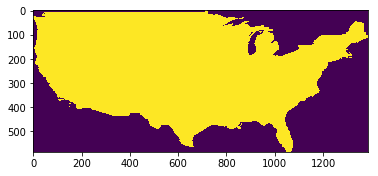

In [5]:
import matplotlib.pyplot as plt
plt.imshow(array)
plt.show()

In [34]:
print(src.transform)
print(src.meta)
print(src.meta['nodata'])
src.close()

| 0.04, 0.00,-124.79|
| 0.00,-0.04, 49.42|
| 0.00, 0.00, 1.00|
{'driver': 'netCDF', 'dtype': 'float32', 'nodata': -32767.0, 'width': 1386, 'height': 585, 'count': 90, 'crs': None, 'transform': Affine(0.041666666666666664, 0.0, -124.78749996666667,
       0.0, -0.04166666666666668, 49.42083333333334)}
-32767.0


<class 'affine.Affine'> {'driver': 'netCDF', 'dtype': 'float32', 'nodata': -32767.0, 'width': 1386, 'height': 585, 'count': 90, 'crs': None, 'transform': Affine(0.041666666666666664, 0.0, -124.78749996666667,
       0.0, -0.04166666666666668, 49.42083333333334)}


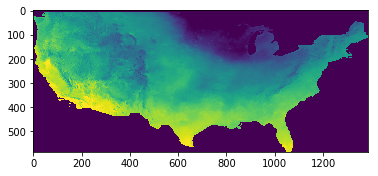

<bound method _AxesBase.axis of <matplotlib.axes._subplots.AxesSubplot object at 0x0000024FA700F278>>
     POI_ID                                           geometry  hru_id_nat  \
0  10054896  POLYGON ((-76.58883845899999 36.74653056200003...        2463   
1  10054896  (POLYGON ((-76.46904191499993 36.7791440250000...        2464   
2  10054884  POLYGON ((-76.65698387399993 36.85365225800007...        2465   
3  10054884  POLYGON ((-76.62364401799994 36.86489843200007...        2466   
4   8526515  POLYGON ((-79.99363256999999 37.44257329500005...        2467   

   hru_id_reg region  tmax_count    tmax_max   tmax_mean    tmax_min  
0           1     02           4  281.299988  281.175003  281.100006  
1           2     02          12  281.399994  281.233335  281.100006  
2           3     02          14  281.500000  281.314285  281.100006  
3           4     02           6  281.399994  281.233332  281.100006  
4           5     02           5  276.299988  275.440002  274.600006  


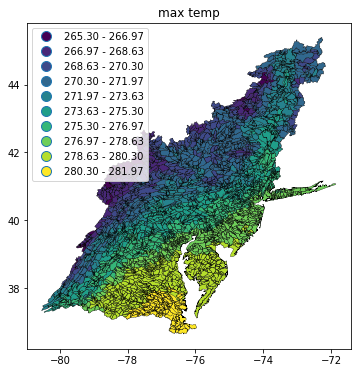

In [39]:
import rasterio.plot as rioplot
import cartopy.crs as ccrs
from rasterstats import zonal_stats

# print(transform)
with rasterio.open(r'netcdf:../Data/test2.nc:daily_maximum_temperature') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
#     src.close()
rasterdata = rasterio.open(r'netcdf:../Data/test2.nc:daily_maximum_temperature')
# tmp = rioplot.show(rasterdata.read(1), with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
plt.imshow(array, cmap='viridis', aspect='equal', vmin=255, vmax=295)
plt.show()
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'../Data/nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True, nodata=src.meta['nodata'])
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})